In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, hstack, vstack
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import random
import pandas as pd

In [2]:
train = np.load("training_data.npz")["data"]
test = np.load("testing.npz")["data"]

In [3]:
X = train[:, 1:-1]
Y = train[:, -1]

tst = test[:, 1:]

In [4]:
encoder = OneHotEncoder()
scaler = StandardScaler(with_mean=False)

scaler.fit(X)
xScaled = scaler.transform(X)
tstScaled = scaler.transform(tst)

xSparse = csr_matrix(xScaled)
tstSparse = csr_matrix(tstScaled)

Y = encoder.fit_transform(Y.reshape(-1, 1)).toarray()

In [5]:
def crossEntropyLoss(yTrue, yPred):
    return -np.sum(yTrue * np.log(yPred + 1e-8), axis=1).mean()

def logisticRegression(xTrain, yTrain, eta, lmbda, itera, minItera, tol):
    m = xTrain.shape[0]
    k = yTrain.shape[1]
    n = xTrain.shape[1]
    X = hstack([csr_matrix(np.ones((m,1))), xTrain])
    delta = yTrain.T
    W = np.random.normal(loc=0, scale=0.01, size=(k, n+1))

    losses = []
    prevLoss = np.inf

    for iteration in range(itera):
        logits = np.exp(W @ X.T - np.max(W @ X.T, axis = 0, keepdims = True))
        probability = logits / np.sum(logits, axis=0)
        error = (delta - probability) @ X
        W = W + eta * (error - (lmbda * W))

        loss = crossEntropyLoss(delta.T, probability.T) + (lmbda / 2) * np.sum(W**2)
        losses.append(loss)

        if prevLoss - loss < tol and iteration > minItera:
            break
        prevLoss = loss
        
    return W, losses

In [6]:
def predict(W, xTest):
    m = xTest.shape[0]
    X = hstack([csr_matrix(np.ones((m,1))), xTest])
    logits = W @ X.T
    probabilities = np.exp(logits - np.max(logits, axis=0, keepdims=True))
    probabilities /= np.sum(probabilities, axis=0)
    yPred = np.argmax(probabilities, axis=0)
    return yPred

In [11]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=26000) 
xChi = selector.fit_transform(xSparse, Y)
xTest = selector.transform(tstSparse)
xTrain, xVal, yTrain, yVal = train_test_split(xChi, Y, test_size=0.33, random_state=42)

In [20]:
W, trainLoss = logisticRegression(xTrain, yTrain, eta = 0.1, lmbda=0.01, itera=1000, minItera= 10, tol=1e-5)
yPred = predict(W, xVal)
accuracy = np.mean(np.argmax(yVal, axis=1) == yPred)
print("Accuracy:", accuracy)

Accuracy: 0.872979797979798 eta: 0.007 lambda 0.003


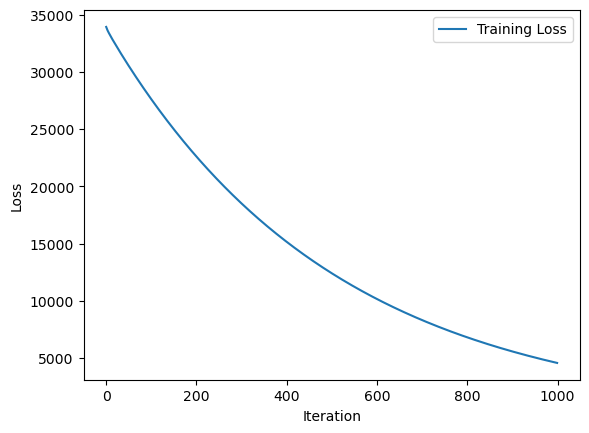

In [21]:
import matplotlib.pyplot as plt

plt.plot(trainLoss, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
import pandas as pd
yPred = predict(W, xTest) + 1

predictions = pd.DataFrame(pd.DataFrame(yPred))
predictions.columns = ["class"]
predictions.index = np.arange(1, len(predictions) + 1)
predictions.set_index(pd.Index(range(12001, 12001 + len(predictions))), inplace=True)
predictions.index.name='id'
predictions.head()
predictions.to_csv("predicions.csv")